In [41]:
import pandas as pd
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [42]:
file_path = os.path.join('..', 'aggregated_data.csv')
data = pd.read_csv(file_path)

# inflation adjustment
base_cpi = data['CPI_US'].iloc[-1]
data['AVG_PRICE_AUCTION'] = data['AVG_PRICE_AUCTION'] * (base_cpi/data['CPI_US'])
data['CORN_FUTURES_TYPICAL_PRICE'] = data['CORN_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] = data['FEEDER_CATTLE_FUTURES_TYPICAL_PRICE'] * (base_cpi/data['CPI_US'])
data['US_MXN_RATES'] = data['US_MXN_RATES'] * (base_cpi/data['CPI_US'])
data['DIESEL_RETAIL_PRICE'] = data['DIESEL_RETAIL_PRICE'] * (base_cpi/data['CPI_US'])
data['DATE'] = pd.to_datetime(data['DATE'])

data = data.sort_values('DATE', ignore_index=True).set_index('DATE').drop( # drop columns not used for training
    ['avg_price_steers_ML1', 
     'avg_price_steers_ML1_2', 
     'avg_price_heifers_ML1', 
     'avg_price_heifers_ML1_2', 
     'NATIONAL_AUCTION_SALES', 
     'NATIONAL_TOTAL_SALES', 
     'TEXAS_AUCTION_SALES', 
     'CORN_FUTURES_TYPICAL_PRICE', 
     'DIESEL_RETAIL_PRICE', 
     'ALFAFA_HAY_PPI', 
     'CORN_PPI',
    #  'US_MXN_RATES',
     ], axis=1)
print(data.columns)


Index(['AVG_PRICE_AUCTION', 'FEEDER_CATTLE_FUTURES_TYPICAL_PRICE',
       'US_MXN_RATES', 'CPI_US', 'FEDERAL_INTEREST_RATE'],
      dtype='object')


In [ ]:
def evaluate_forecast(model_name, actual, predicted):
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    r2 = r2_score(actual,predicted)
    
    acc = 100.0 * (1 - mae / actual.mean()) if actual.mean() != 0 else float('nan')
    print(f"\n[{model_name}] Test Performance:")
    print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.2f}, Accuracy: {acc:.2f}%")

In [44]:
# create datasets
X, y = data.drop(columns=['AVG_PRICE_AUCTION']), data.AVG_PRICE_AUCTION.values

mm = MinMaxScaler()
ss = StandardScaler()

# standardize traianing features X by removing mean & scaling to unit variance
# scale and translaate feature Y to between 0 and 1.
X_trans = ss.fit_transform(X)
y_trans = mm.fit_transform(y.reshape(-1,1))

print(X.shape)

(369, 4)


In [ ]:
# split a multivariate sequence into past, future samples (X and y)
def split_sequences(input_sequences, output_sequence, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(input_sequences)): # find end of input, output sequence
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out - 1
        if out_end_ix > len(input_sequences): break #check if we are out of bounds
        seq_x, seq_y = input_sequences[i:end_ix], output_sequence[end_ix-1:out_end_ix, -1] # gather input & output of pattern
        X.append(seq_x), y.append(seq_y)
    return np.array(X), np.array(y)

steps_in, steps_out = 16,8

X_ss, y_mm = split_sequences(X_trans, y_trans, steps_in, steps_out)
print(X_ss.shape, y_mm.shape)

(347, 16, 4) (347, 8)


In [46]:
total_samples = len(X)
train_test_cutoff = round(0.85 * total_samples)
print(train_test_cutoff)

X_train = X_ss[:-(steps_in+steps_out)]
X_test = X_ss[-(steps_in+steps_out):]

y_train = y_mm[:-(steps_in+steps_out)]
y_test = y_mm[-(steps_in+steps_out):]

print('Training Shape: ', X_train.shape, y_train.shape)
print('Testing Shape: ', X_test.shape, y_test.shape)

314
Training Shape:  (323, 16, 4) (323, 8)
Testing Shape:  (24, 16, 4) (24, 8)


In [47]:
# convert to pytorch tensors
X_train_tensors = torch.tensor(X_train, dtype=torch.float32)
X_test_tensors = torch.tensor(X_test, dtype=torch.float32)

y_train_tensors = torch.tensor(y_train, dtype=torch.float32)
y_test_tensors = torch.tensor(y_test, dtype=torch.float32)

X_train_tensors.requires_grad = True

print('Training Tensors Shape: ', X_train_tensors.shape, y_train_tensors.shape)
print('Testing Tensors Shape: ', X_test_tensors.shape, y_test_tensors.shape)

Training Tensors Shape:  torch.Size([323, 16, 4]) torch.Size([323, 8])
Testing Tensors Shape:  torch.Size([24, 16, 4]) torch.Size([24, 8])


In [48]:
# reshape to rows, timestamps, features
X_train_tensors_final = torch.reshape(X_train_tensors, (X_train_tensors.shape[0], steps_in, X_train_tensors.shape[2]))
X_test_tensors_final = torch.reshape(X_test_tensors, (X_test_tensors.shape[0], steps_in, X_test_tensors.shape[2]))

print("Training Shape:", X_train_tensors_final.shape, y_train_tensors.shape)
print("Testing Shape:", X_test_tensors_final.shape, y_test_tensors.shape) 

Training Shape: torch.Size([323, 16, 4]) torch.Size([323, 8])
Testing Shape: torch.Size([24, 16, 4]) torch.Size([24, 8])


In [49]:
# checking that the steps_out predicted values match the last steps_out values in y
X_check, y_check = split_sequences(X, y.reshape(-1, 1), steps_in, steps_out)
print(X_check[-1][0:4])
X.iloc[-(steps_in+steps_out-1):-(steps_in+steps_out-1-4)]

[[  2.45236113  19.84584978 314.796        5.33      ]
 [  2.40427051  20.01947628 315.301        5.33      ]
 [  2.41505094  19.83971516 315.301        5.33      ]
 [  2.45352128  19.40194919 315.301        5.33      ]]


,FEEDER_CATTLE_FUTURES_TYPICAL_PRICE,US_MXN_RATES,CPI_US,FEDERAL_INTEREST_RATE
DATE,,,,
2024-08-30,2.452361,19.845850,314.796,5.33
2024-09-06,2.404271,20.019476,315.301,5.33
2024-09-13,2.415051,19.839715,315.301,5.33
2024-09-20,2.453521,19.401949,315.301,5.33


In [50]:
# checking that the final batch sample in test targets matches the prediction dates
print(y_check[-1])
print(data.AVG_PRICE_AUCTION.values[-steps_out:])

[280.50931587 280.75340331 283.97875    289.03       287.56
 293.9675     296.8425     292.9325    ]
[280.50931587 280.75340331 283.97875    289.03       287.56
 293.9675     296.8425     292.9325    ]


In [51]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super().__init__()
        self.num_classes = num_classes # output size
        self.input_size = input_size   # input size
        self.hidden_size = hidden_size # neurons in each lstm layer
        self.num_layers = num_layers   # num of recurrent layers in the lstm
        # ------ LSTM model ------ #
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc_1 = nn.Linear(hidden_size, 128) # fully connected 
        self.fc_2 = nn.Linear(128, num_classes) # fully connected last layer
        self.relu = nn.ReLU()

    def forward(self,x):
        h_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # hidden state
        c_0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device) # cell state
        # propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) # (input, hidden, and internal state)
        hn = hn.view(-1, self.hidden_size) # reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) # first dense
        out = self.relu(out) # relu
        out = self.fc_2(out) # final output
        return out

In [52]:
def training_loop(n_epochs, lstm, optimiser, loss_fn, X_train, y_train, X_test, y_test):
    for epoch in range(n_epochs):
        lstm.train()
        outputs = lstm.forward(X_train) # forward pass
        optimiser.zero_grad() # calculate the gradient, manually setting to 0
        # obtain the loss function
        loss = loss_fn(outputs, y_train)
        loss.backward() # calculates the loss of the loss function
        optimiser.step() # improve from loss
        # test loss
        lstm.eval()
        test_preds = lstm(X_test)
        test_loss = loss_fn(test_preds, y_test)
        if epoch % 100 == 0:
            print("Epoch: %d, train loss: %1.5f, test loss: %1.5f" % (epoch, loss.item(), test_loss.item())) 

In [53]:
import warnings
warnings.filterwarnings('ignore')

n_epochs = 3000 # 3000 epochs
learning_rate = 0.001 # 0.001 lr

input_size = 4 # number of features
hidden_size = 2 # number of features in hidden state
num_layers = 1 # number of stacked lstm layers

num_classes = steps_out # number of output classes 

lstm = LSTM(num_classes, input_size, hidden_size, num_layers)

In [54]:
loss_fn = torch.nn.MSELoss()    # mean-squared error for regression
optimiser = torch.optim.Adam(lstm.parameters(), lr=learning_rate)

training_loop(n_epochs=n_epochs,
              lstm=lstm,
              optimiser=optimiser,
              loss_fn=loss_fn,
              X_train=X_train_tensors_final,
              y_train=y_train_tensors,
              X_test=X_test_tensors_final,
              y_test=y_test_tensors)

Epoch: 0, train loss: 0.21032, test loss: 0.69828


Epoch: 100, train loss: 0.00929, test loss: 0.03517
Epoch: 200, train loss: 0.00388, test loss: 0.00953
Epoch: 300, train loss: 0.00336, test loss: 0.00937
Epoch: 400, train loss: 0.00298, test loss: 0.01021
Epoch: 500, train loss: 0.00269, test loss: 0.01193
Epoch: 600, train loss: 0.00249, test loss: 0.01445
Epoch: 700, train loss: 0.00236, test loss: 0.01782
Epoch: 800, train loss: 0.00227, test loss: 0.02142
Epoch: 900, train loss: 0.00219, test loss: 0.02446
Epoch: 1000, train loss: 0.00212, test loss: 0.02451
Epoch: 1100, train loss: 0.00207, test loss: 0.02225
Epoch: 1200, train loss: 0.00204, test loss: 0.01993
Epoch: 1300, train loss: 0.00202, test loss: 0.01790
Epoch: 1400, train loss: 0.00200, test loss: 0.01632
Epoch: 1500, train loss: 0.00198, test loss: 0.01471
Epoch: 1600, train loss: 0.00196, test loss: 0.01274
Epoch: 1700, train loss: 0.00194, test loss: 0.01131
Epoch: 1800, train loss: 0.00193, test loss: 0.01011
Epoch: 1900, train loss: 0.00192, test loss: 0.00910
Ep

In [ ]:
df_X_ss = ss.transform(data.drop(columns=['AVG_PRICE_AUCTION'])) # old transformers
df_y_mm = mm.transform(data.AVG_PRICE_AUCTION.values.reshape(-1, 1)) # old transformers
# split the sequence
df_X_ss, df_y_mm = split_sequences(df_X_ss, df_y_mm, steps_in, steps_out)
# converting to tensors
df_X_ss = torch.Tensor(df_X_ss)
df_y_mm = torch.Tensor(df_y_mm)
# reshaping the dataset
df_X_ss = torch.reshape(df_X_ss, (df_X_ss.shape[0], steps_in, df_X_ss.shape[2]))

train_predict = lstm(df_X_ss) # forward pass
data_predict = train_predict.data.numpy() # numpy conversion
dataY_plot = df_y_mm.data.numpy()

data_predict = mm.inverse_transform(data_predict) # reverse transformation
dataY_plot = mm.inverse_transform(dataY_plot)
true, preds = [], []
for i in range(len(dataY_plot)):
    true.append(dataY_plot[i][0])
for i in range(len(data_predict)):
    preds.append(data_predict[i][0])

train_y_actual = np.array(true)
train_y_preds = np.array(preds)
    
plt.figure(figsize=(15, 8)) #plotting
plt.plot(train_y_actual, label='Actual Data') # actual plot
plt.plot(train_y_preds, label='Predicted Data') # predicted plot
plt.title('Time-Series Prediction for Training Data')

plt.legend()
plt.savefig(os.path.join('..', 'figures', 'lstm_training_plot.png'), dpi=300)
plt.show() 


[LSTM: Training Data] Test Performance:
MAE: 5.28, RMSE: 7.11, R²: 0.96, Accuracy: 97.26%


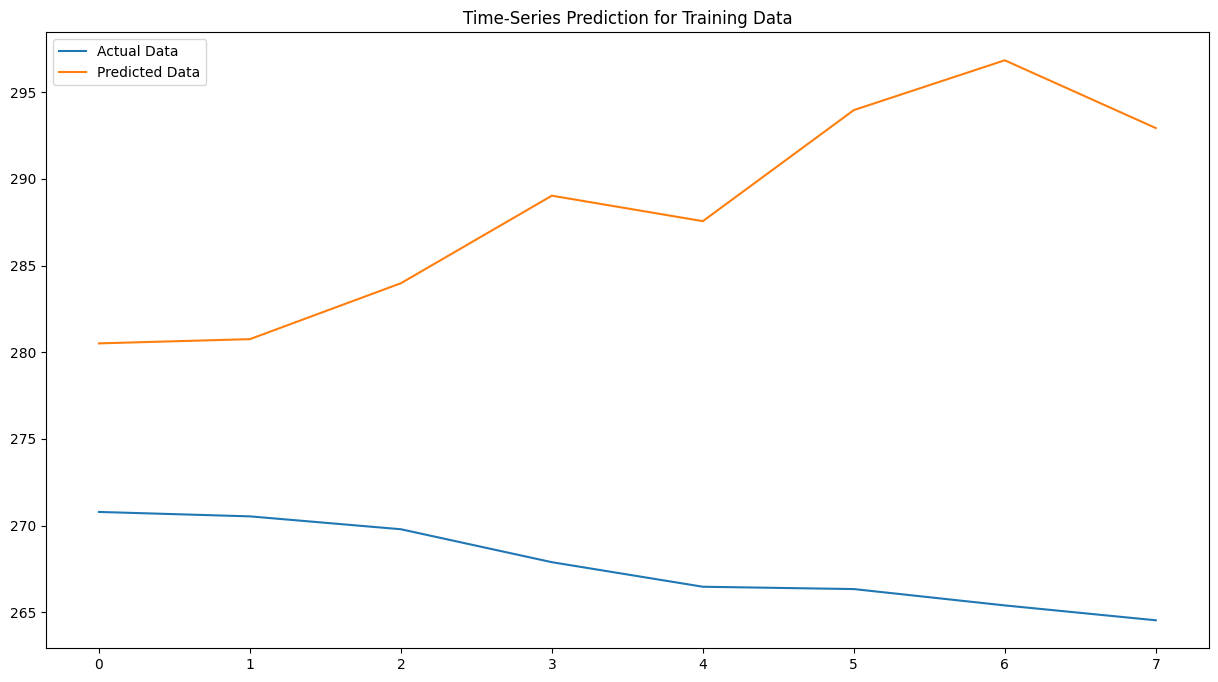


[LSTM] Test Performance:
MAE: 20.48, RMSE: 21.94, R²: -13.60, Accuracy: 92.89%


In [ ]:
test_predict = lstm(X_test_tensors_final[-1].unsqueeze(0)) # get the last sample
test_predict = test_predict.detach().numpy()
test_predict = mm.inverse_transform(test_predict)
test_predict = test_predict[0]

test_target = y_test_tensors[-1].detach().numpy() # last sample again
test_target = mm.inverse_transform(test_target.reshape(1, -1))
test_target = test_target[0]

plt.figure(figsize=(15, 8))

plt.plot(test_predict, label='Actual Data') # actual plot
plt.plot(test_target, label='Predicted Data') # predicted plot

plt.title('Time-Series Prediction for Training Data')
plt.legend()
plt.savefig(os.path.join('..', 'figures', 'lstm_training_plot.png'), dpi=300)
plt.show() 


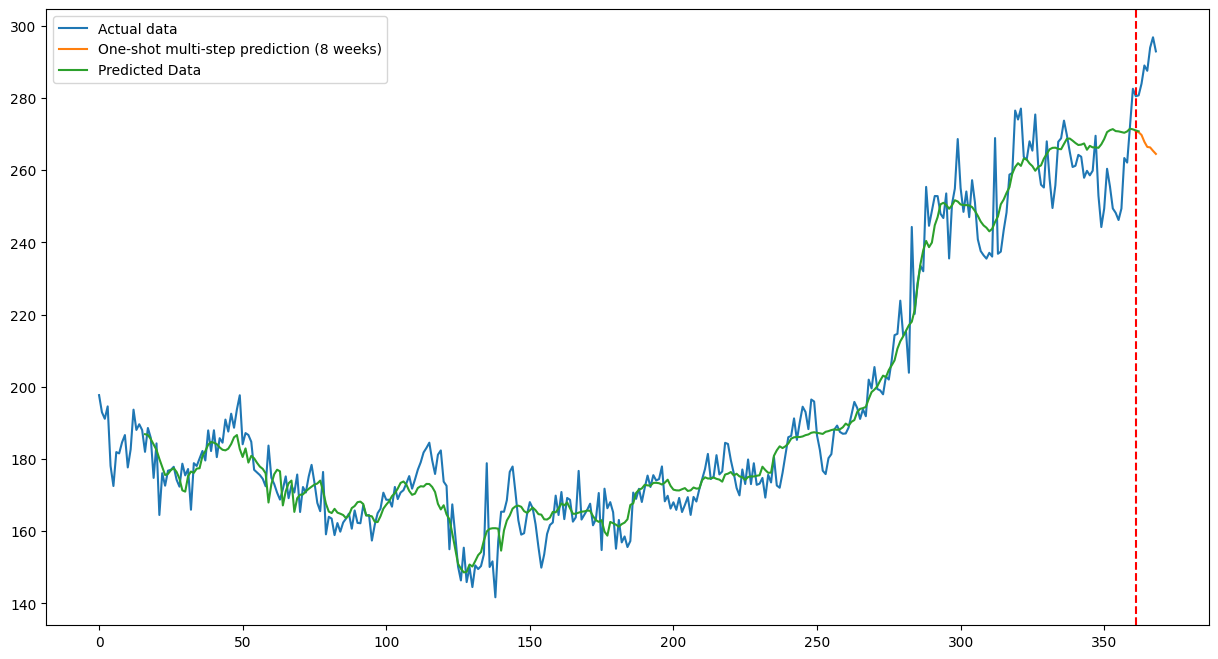


[LSTM: Training Data] Test Performance:
MAE: 5.28, RMSE: 7.11, R²: 0.96, Accuracy: 97.26%

[LSTM: Testing Data] Test Performance:
MAE: 20.48, RMSE: 21.94, R²: -13.60, Accuracy: 92.89%


In [114]:
plt.figure(figsize=(15, 8)) #plotting
a = [x for x in range(0, len(y))]
plt.plot(a, y, label='Actual data');
c = [x for x in range(len(y)-steps_out, len(y))]
d = [x for x in range(steps_in, len(y)-steps_out+2)]
plt.plot(c, test_predict, label=f'One-shot multi-step prediction ({steps_out} weeks)')
plt.plot(d, preds, label='Predicted Data') # predicted plot
plt.axvline(x=len(y)-steps_out, c='r', linestyle='--')
plt.legend()
plt.show()

evaluate_forecast('LSTM: Training Data', train_y_actual, train_y_preds)
evaluate_forecast('LSTM: Testing Data', test_target, test_predict)